
# Modeling



In [1]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from statsmodels.tsa.stattools import adfuller

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
plot_confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbpipline


## Read in master dataset and drop columns not needed for modeling

---

<p>The following columns are dropped:
    <ul>
        <li><b>Column : Reason</b></li>
        <li>Out Duration : Feature engineered total_duration</li>
        <li>Return Duration : Feature engineered total_duration</li>
        <li>timestamp : Not needed for modeling</li>
        <li>Out Time : Feature engineered dep_time</li>
        <li>Return Time : Feature engineered ret_time</li>
        <li>sort : Not needed for modeling</li>
        <li>Out Stop Cities : Layover cities not needed for modeling</li>
        <li>Return Stop Cities : Layover cities not needed for modeling</li>
        <li>Out Airline : Feature engineered dep_airline</li>
        <li>Return Airline : Feature engineered ret_airline</li>
        <li>Out Stops : Feature engineered total_stops</li>
        <li>Return Stops : Feature engineered total_stops</li>
    </ul>
This was done to reduce dimensionality and resolve any possible redundancies from the feature engineering</p>

In [2]:
df = pd.read_csv('data/masterdf.csv')
col_to_drop = ['Out Duration', 'Return Duration', 'timestamp', 'Out Time', 
                 'Return Time', 'sort', 'Out Stop Cities', 'Return Stop Cities',
                'Out Airline', 'Return Airline', 'Out Stops', 'Return Stops']
df = df.drop(col_to_drop, axis = 1)
df.head()

,Out Cities,Return Cities,Price,departure_date,total_duration,dep_time,ret_time,record_time,dep_airline,ret_airline,departure_day,search_day,total_stops,target,time_diff
0,EWR‐SIN,SIN‐EWR,951,2022-04-10,3245,8:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0,7
1,EWR‐SIN,SIN‐EWR,979,2022-04-10,3185,9:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0,7
2,EWR‐SIN,SIN‐EWR,994,2022-04-10,2860,11:25,6:10,14,ANA,ANA,Sunday,Sunday,2,1,7
3,EWR‐SIN,SIN‐EWR,994,2022-04-10,3155,6:30,6:10,14,ANA,ANA,Sunday,Sunday,3,0,7
4,EWR‐SIN,SIN‐EWR,998,2022-04-10,3627,11:25,10:10,14,ANA,ANA,Sunday,Sunday,3,0,7



# Defining Functions for

<ol><b>
    <li>Modeling Pipelines</li>
    <li>Printing Scores and Confusion Matrix</li>
    <li>Returning GridSearch Optimized Parameters and Score</li>
    <li>Printing Results of DickeyFuller Test</li>
</b></ol>

---

In [3]:
# Function to fit model and print results from score_matrix_printer
def model_fit_print(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)
    
    model.fit(X_train, y_train)
    score_matrix_printer(model, X_train, y_train, X_test, y_test)

def score_matrix_printer(model, X_train, y_train, X_test, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Cleaning up scores to be more visually appealing
    ascore_train = round((accuracy_score(y_train, train_pred) * 100), 2)
    pscore_train = round((precision_score(y_train, train_pred) * 100), 2)
    rscore_train = round((recall_score(y_train, train_pred) * 100), 2)
    
    ascore_test = round((accuracy_score(y_test, test_pred) * 100), 2)
    pscore_test = round((precision_score(y_test, test_pred) * 100), 2)
    rscore_test = round((recall_score(y_test, test_pred) * 100), 2)
    # Display confusion matrix
    conf_mat = plot_confusion_matrix(model, X_test, y_test)
    # Print Accuracy and Precision for both training and test in a structured format
    print(f"""
    Train Accuracy: {ascore_train}%
    Train Precision: {pscore_train}%
    ==============================
    Test Accuracy: {ascore_test}%
    Test Precision: {pscore_test}%
    """)

In [4]:
# Function to print results from GridSearch in a structured format
def grid_result(grid_model):
    print(f"""
    Optimized score and Parameters
    ==============================
    Score: {grid_model.best_score_}
    ==============================
    Parameters: {grid_model.best_params_}
    """)

In [5]:
# importing relevant library
from statsmodels.tsa.stattools import adfuller

# For testing stationarity
def dicky_fuller(ts):
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(
                    dftest[0:4], 
                    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    alpha = 0.05
    is_stationary = dftest[1] < alpha
    if is_stationary == True:
        print(f'The data is stationary with a fuller score of {round(dftest[1],3)}')
    else:
        print(f'The data is not stationary with a fuller score of {round(dftest[1],3)}')
        
    display(dfoutput)

In [6]:
X = df.drop('target', axis=1)
y = df['target']

In [7]:
# numeric_features = X.select_dtypes(exclude="object")
# numeric_features
# ss = StandardScaler()
# num_df = pd.DataFrame(ss.fit_transform(numeric_features),
#                      columns = numeric_features.columns,
#                      index = numeric_features.index)
# num_df.head()


# Instantiating Column Transformer for Pipelines

---

Here I am creating the process for One Hot Encoding my categorical variables and scaling the numeric variables

In [8]:
# ColumnTransformer to handle numerics and categoricals for pipelines
numeric_features = X.select_dtypes(exclude="object").columns
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())] # Standard Scaler is used because we have outliers present
)

categorical_features = X.select_dtypes(include="object").columns
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [9]:
from sklearn.dummy import DummyClassifier

In [10]:
def num_encoder(df_to_encode):
    ss = StandardScaler()

    ss.fit(df_to_encode)
    nums_df = pd.DataFrame(ss.transform(df_to_encode),
                           columns = df_to_encode.columns,
                          index = df_to_encode.index)
    return nums_df

def cat_encoder(df_to_encode):
    ohe = OneHotEncoder(
        drop = 'first',
        sparse = False)
    
    cats = ohe.fit_transform(df_to_encode)
    cat_df = pd.DataFrame(cats,
                            columns = ohe.get_feature_names(),
                            index = df_to_encode.index)
    return cat_df

def split_join(split):
    categories = split.select_dtypes('object')
    numerics = split.select_dtypes(['float64', 'int64'])

    joined = pd.concat([num_encoder(numerics), cat_encoder(categories)], axis = 1)
    return joined

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)
X_train_clean = split_join(X_train)
X_test_clean = split_join(X_test)


# Baseline Model

---

Dummy Classifier was used for the Baseline Model<br>
    Producing a score of <b>50.63%</b>

In [12]:
# Baseline model
baseline = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ("dummy", DummyClassifier(strategy= 'uniform', random_state=32))
])

baseline.fit(X_train, y_train)
baseline.score(X_test, y_test)

0.5063015191770557


# Model One Logistic Regression Model

---

<p>For the first model I chose a Logistic Regression Model<br>
    This was done to see how it would preform before conducting any oversampling<br>
    We see that it has a
    <ul>
        <li><b>Accuracy Score of 99.26%</b></li>
        <li><b>Precision Score of 84.13%</b></li>
    </ul>
It may seem good, but knowing that I need to address the class imbalance present in my data means that this is not an accurate representation of my model's performance</p>


    Train Accuracy: 99.26%
    Train Precision: 90.38%
    Test Accuracy: 99.05%
    Test Precision: 84.13%
    


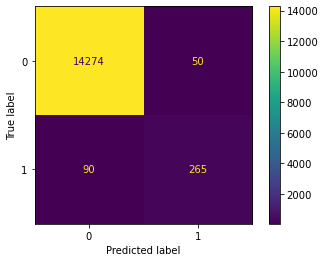

In [13]:
# Logistic Regression model
logreg_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ("logreg", LogisticRegression(max_iter = 1000, random_state=32)) # max_iter called to resolve warning
])

model_fit_print(logreg_model, X, y)

In [14]:
df['target'].value_counts(normalize=True) # To show class imbalance

0    0.976087
1    0.023913
Name: target, dtype: float64


## After oversampling to deal with class imbalance

We see that 
<ul>
    <li><b>Accuracy Score decreased to 97.72%</b></li>
    <li><b>Precision Score decreased to 51.54%</b></li>
</ul>
This is still an improvement from our baseline model, but the precision is not ideal


    Train Accuracy: 98.24%
    Train Precision: 57.48%
    Test Accuracy: 97.72%
    Test Precision: 51.54%
    


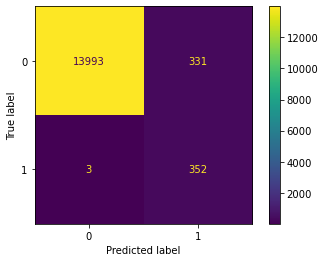

In [15]:
model_1 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("logreg", LogisticRegression(max_iter = 1000, random_state=32)) # max_iter called to resolve warning
])

model_fit_print(model_1, X, y)


# Model Two Decision Tree Classifier

---

<p>The next model I decided to use was a Decison Tree Classifier to improve the precision score
    For the first iteration I did not declare any stop parameters
    As expected the model is severly overfit producing a
<ul>
    <li><b>Training Accuracy Score of 100%</b></li>
    <li><b>Training Precision Score of 100%</b></li>
    ============And============
    <li><b>Testing Accuracy Score of 99.73%</b></li>
    <li><b>Testing Precision Score of 94.38%</b></li>
</ul>
</p> 


    Train Accuracy: 100.0%
    Train Precision: 100.0%
    Test Accuracy: 99.73%
    Test Precision: 94.38%
    


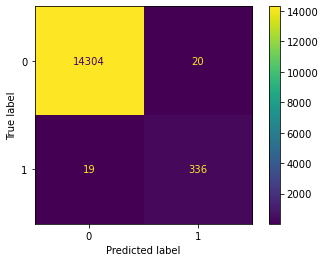

In [16]:
dtree_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("dtree", DecisionTreeClassifier(random_state=32))
])

model_fit_print(dtree_model, X, y)


## Finding Optimal Parameters with GridSearch

<p>To address the overfitting and in addition find the optimal parameters for the Decision Tree Classifier I implemented Grid Seach with the following parameters:<br>
<code>"criterion":['gini', 'entropy'],
"max_depth":[1, 10, 25, 50],
"min_samples_split":range(1, 10),
"min_samples_leaf":range(1, 10)</code><br>
==========================================<br>
After running the GridSearch it return the following as optimal parameters:<br>
<code>criterion= 'entropy'
max_depth= 25 
min_samples_split= 4
min_samples_leaf= 1</code><p>

In [17]:
# # Approximately 5 minute run time
# param_dict = {
#     "dtree__criterion":['gini', 'entropy'],
#     "dtree__max_depth":[1, 10, 25, 50],
#     "dtree__min_samples_split":range(1, 10),
#     "dtree__min_samples_leaf":range(1, 10)
# }

# gs = GridSearchCV(estimator=dtree_model,
#                  param_grid=param_dict,
#                  cv=10,
#                  verbose=1,
#                  n_jobs=-1)

# gs.fit(X_train, y_train)
# grid_result(gs)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  5.0min finished



    Optimized score and Parameters
    Score: 0.9995685121386355
    Parameters: {'dtree__criterion': 'entropy', 'dtree__max_depth': 25, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 4}
    



## After running with the optimal parameters

We see that 
<ul>
    <li><b>Training Accuracy Score 100%</b></li>
    <li><b>Training Precision Score 100%</b></li>
    ============And============
    <li><b>Testing Accuracy Score increased to 99.93%</b></li>
    <li><b>Testing Precision Score increased to 99.71%</b></li>
</ul>
These scores are extremely good and the overfitting has been resolved!


    Train Accuracy: 100.0%
    Train Precision: 100.0%
    Test Accuracy: 99.93%
    Test Precision: 99.71%
    


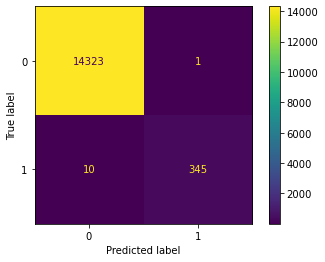

In [39]:
dtree_model2 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("dtree", DecisionTreeClassifier(criterion= 'entropy', max_depth= 25, min_samples_split= 4,
                                    min_samples_leaf= 1, random_state= 32))
])

model_fit_print(dtree_model2, X, y)

In [19]:
# knn_model = imbpipline(steps=[
#     ("preprocessor", preprocessor),
#     ('SMOTE', SMOTE(random_state = 32)),
#     ("knn", KNeighborsClassifier())
# ])

# model_fit_print(knn_model, X, y)

In [20]:
# # Approximately 17 minute run time
# param_dict = {
#     'knn__n_neighbors': range(5, 15),
#     'knn__metric': ['manhattan', 'minkowski', 'euclidean'],
#     'knn__weights' : ['distance', 'uniform']
# }

# gs = GridSearchCV(estimator=knn_model,
#                  param_grid=param_dict,
#                  cv=10,
#                  verbose=1,
#                  n_jobs=-1)

# gs.fit(X_train, y_train)
# grid_result(gs)

In [21]:
# knn_model2 = imbpipline(steps=[
#     ("preprocessor", preprocessor),
#     ('SMOTE', SMOTE(random_state = 32)),
#     ("knn", KNeighborsClassifier(n_neighbors= 5, metric= 'manhattan', weights= 'distance'))
# ])

# model_fit_print(knn_model2, X, y)


# Model Three Random Forest Classifier

---

<p>For the third model I decided to use a RFC (Random Forest Classifier) because of how well the optimized Decision Tree Classifier performed. After running an initial RFC with no stopping parameters we find that it has amazing performace scores.

<ul>
    <li><b>Training Accuracy Score of 100%</b></li>
    <li><b>Training Precision Score of 100%</b></li>
    ============And============
    <li><b>Testing Accuracy Score of 99.91%</b></li>
    <li><b>Testing Precision Score of 98.31%</b></li>
</ul>
However, it is important to remember that without any stopping parameters declared this model is absolutely overfit. Even if the evaluation metrics show amazing model performance</p>


    Train Accuracy: 100.0%
    Train Precision: 100.0%
    Test Accuracy: 99.91%
    Test Precision: 98.31%
    


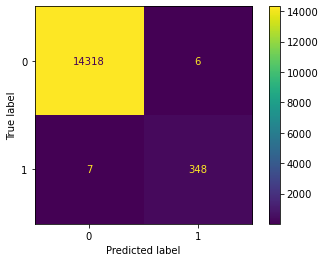

In [22]:
rforest_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("rf", RandomForestClassifier(random_state = 32))
])

model_fit_print(rforest_model, X, y)


## Finding Optimal Parameters with GridSearch

<p>To address the overfitting and in addition find the optimal parameters for the Decision Tree Classifier I implemented Grid Seach with the following parameters:<br>
<code>"n_estimators":[30, 100, 150, 200],
"criterion":['gini', 'entropy'],
"max_depth":[1, 10, 25, 50],
"min_samples_split":range(1, 10),
"min_samples_leaf":range(1, 10)</code><br>
==========================================<br>
After running the GridSearch it return the following as optimal parameters:<br>
<code>criterion = 'gini'
max_depth = 50 
min_samples_split = 7
min_samples_leaf = 2
n_estimators = 100</code><p>

In [23]:
# # Approximately 184 minute run time
# rforest_grid = imbpipline(steps=[
#     ("preprocessor", preprocessor),
#     ('SMOTE', SMOTE(random_state = 32)),
#     ("rf", RandomForestClassifier(random_state = 32))
# ])

# param_grid = {
#     "rf__n_estimators":[30, 100, 150, 200],
#     "rf__criterion":['gini', 'entropy'], 
#     "rf__max_depth":[1, 10, 25, 50],
#     "rf__min_samples_split":range(1, 10),
#     "rf__min_samples_leaf":range(1, 10)
# }            

# gs = GridSearchCV(estimator=rforest_grid,
#                  param_grid=param_grid,
#                  cv=10,
#                  verbose=1,
#                  n_jobs=-1)

# gs.fit(X_train, y_train)
# grid_result(gs)

Fitting 10 folds for each of 2592 candidates, totalling 25920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed: 52.6min
[Parallel(n_jobs=-1)]: Done 11186 tasks      | elapsed: 71.3min
[Parallel(n_jobs=-1)]: Done 12736 tasks    


    Optimized score and Parameters
    Score: 0.999114317646935
    Parameters: {'rf__criterion': 'gini', 'rf__max_depth': 50, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 7, 'rf__n_estimators': 100}
    



## After running with the optimal parameters

<p>We see that 
<ul>
    <li><b>Training Accuracy Score is 99.98%</b></li>
    <li><b>Training Precision Score is 99.71%</b></li>
    ============And============
    <li><b>Testing Accuracy Score decreased to 99.87%</b></li>
    <li><b>Testing Precision Score decreased to 96.67%</b></li>
</ul>
These scores are extremely good and the overfitting has been resolved!<br>
Even though our testing scores dropped, the drop is negligible compared to the benefit of resolving an overfit model</p>


    Train Accuracy: 99.98%
    Train Precision: 99.71%
    Test Accuracy: 99.87%
    Test Precision: 96.67%
    


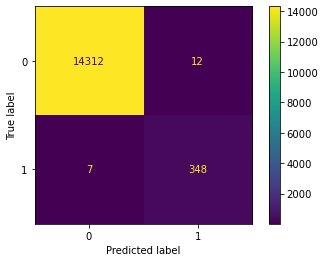

In [40]:
rforest_model2 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("rf", RandomForestClassifier(criterion = 'gini', n_estimators = 100, max_depth = 50,
                                  min_samples_leaf = 2, min_samples_split = 7, random_state = 32))
])

model_fit_print(rforest_model2, X, y)


# Time Series

---

First I create a timeseries with a date time index

In [66]:
tdf2 = df.set_index(pd.to_datetime(df['departure_date']), drop=True)
tdf2 = tdf2.select_dtypes(exclude="object")
tdf2 = tdf2['Price'] # Testing iwht just price
tdf2 = tdf2.resample('D').mean()
tdf2

departure_date
2022-04-10    1760.088889
2022-04-11    1693.311594
2022-04-12    1645.573643
2022-04-13    1721.958791
2022-04-14    1950.081281
                 ...     
2022-08-27    1470.635266
2022-08-28    1489.173077
2022-08-29    1383.706731
2022-08-30    1273.192308
2022-08-31    1305.837709
Freq: D, Name: Price, Length: 144, dtype: float64

Doing a quick analysis with describe we can see that there a decent gap between the min and max

In [74]:
tdf2.describe()

count     144.000000
mean     1789.256563
std       206.104975
min      1273.192308
25%      1678.096653
50%      1777.798753
75%      1939.753614
max      2391.075610
Name: Price, dtype: float64


## Train Test Splitting with a cutoff


In [67]:
cutoff = round(ts_daily_diff.shape[0]*0.8)

# Split train and test
train = tdf2[:cutoff]
test = tdf2[cutoff:]


## Checking for Stationarity


In [71]:
# dicky_fuller(train.values.reshape(-1).tolist()) # Needed to run with all numeric columns
dicky_fuller(train)

The data is not stationary with a fuller score of 0.379


Test Statistic                  -1.803220
p-value                          0.378864
#Lags Used                       9.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64

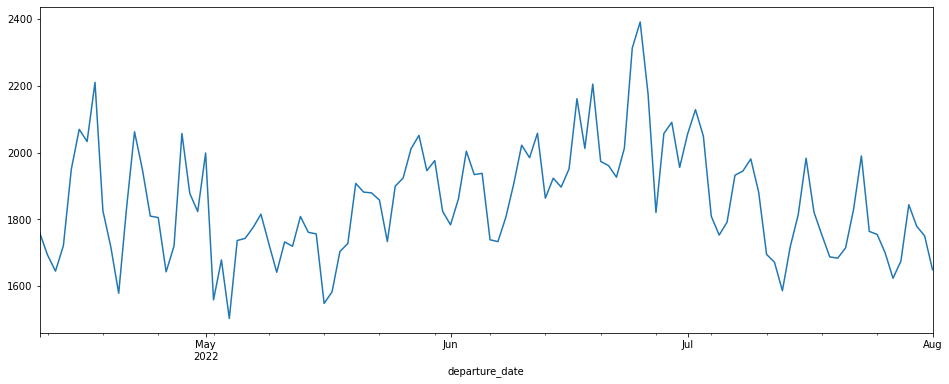

In [69]:
train.plot(figsize = (16,6));


# Random Walk Baseline


In [77]:
import statsmodels.api as sm
random_walk_model = sm.tsa.arima.ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

215.90981178703223

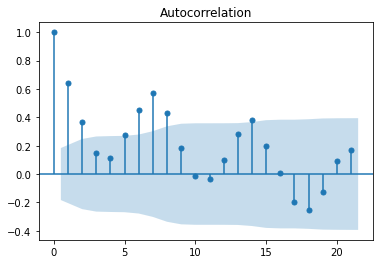

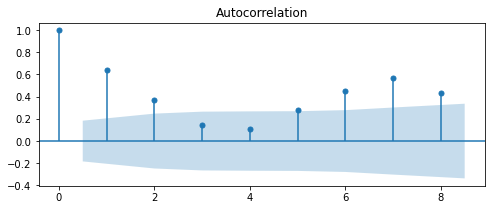

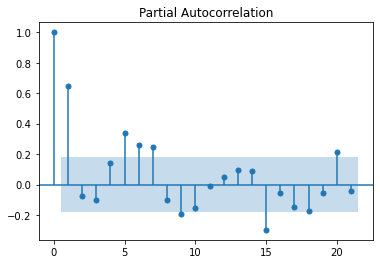

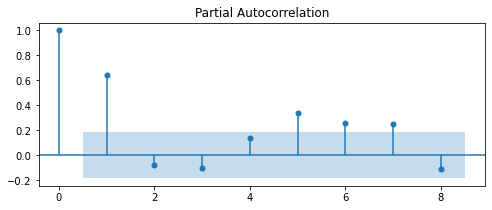

In [78]:
plot_acf(train) #shown below is that an MA term of 2 seems ideal

fig, ax = plt.subplots(figsize=(8,3))
plot_acf(train, ax=ax, lags=8);

plot_pacf(train) #shown below is that an AR term of 1 is ideal

fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(train, ax=ax, lags=8);

In [79]:
ar_1 = sm.tsa.arima.ARIMA(train, order=(1, 1, 2)).fit()
ar_1.predict(typ='levels')
ar_1.summary()

C:\Users\Jun\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  114
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -708.245
Date:                Sun, 10 Apr 2022   AIC                           1424.490
Time:                        17:32:14   BIC                           1435.400
Sample:                    04-10-2022   HQIC                          1428.917
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3727      0.217      1.721      0.085      -0.052       0.797
ma.L1         -0.7050      0.232     -3.042      0.002      -1.159      -0.251
ma.L2         -0.1518      0.161     -0.944      0.345      -0.467       0.163
sigma2      1.616e+04   2079.965      7.767      0.000    1.21e+04    2.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.89   Prob(JB):                         0.85
Heteroskedasticity (H):               0.64   Skew:                            -0.09
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

208.1101823728482

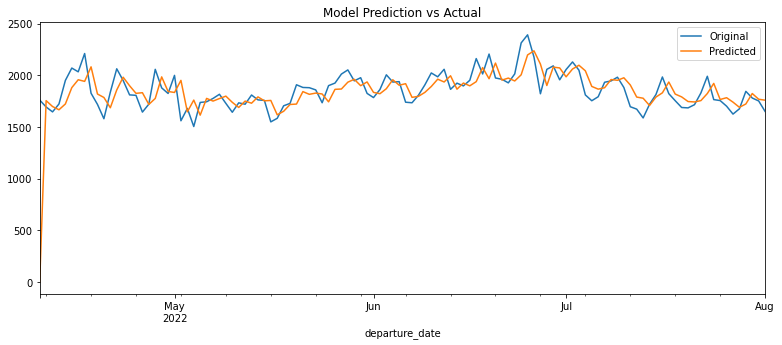

In [97]:
fig, ax = plt.subplots(figsize=(13,5), linewidth=2)
train.plot(ax=ax, label = 'Original')
y_hat_ar1.plot(ax=ax, label = 'Predicted')
ax.set_title('Model Prediction vs Actual')
ax.legend();

---

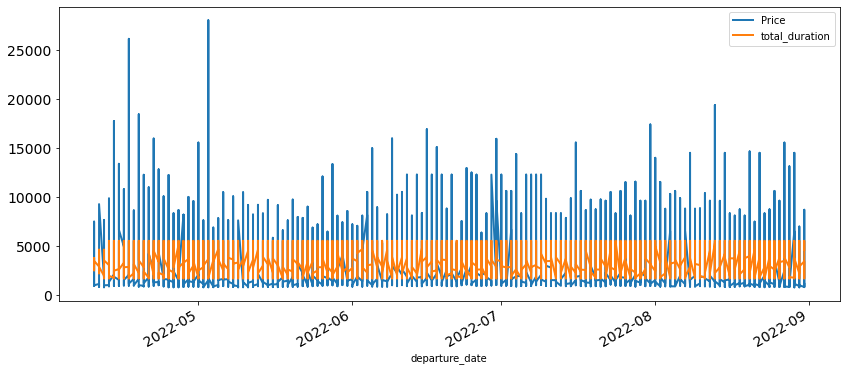

In [25]:
# Set date time index
time_df = df.set_index(pd.to_datetime(df['departure_date']), drop=True)
time_df = time_df.filter(['Price', 'total_duration'], axis=1)

time_df.plot(figsize=(14,6), linewidth=2, fontsize=14);

In [ ]:
cutoff = round(ts_daily_diff.shape[0]*0.8)

# Split train and test
train = ts_daily_diff[:cutoff]
test = ts_daily_diff[cutoff:]

In [26]:
ts = time_df['Price']
dicky_fuller(ts)

The data is stationary with a fuller score of 0.0


Test Statistic                -1.335585e+01
p-value                        5.550941e-25
#Lags Used                     6.000000e+01
Number of Observations Used    5.865200e+04
Critical Value (1%)           -3.430461e+00
Critical Value (5%)           -2.861589e+00
Critical Value (10%)          -2.566796e+00
dtype: float64

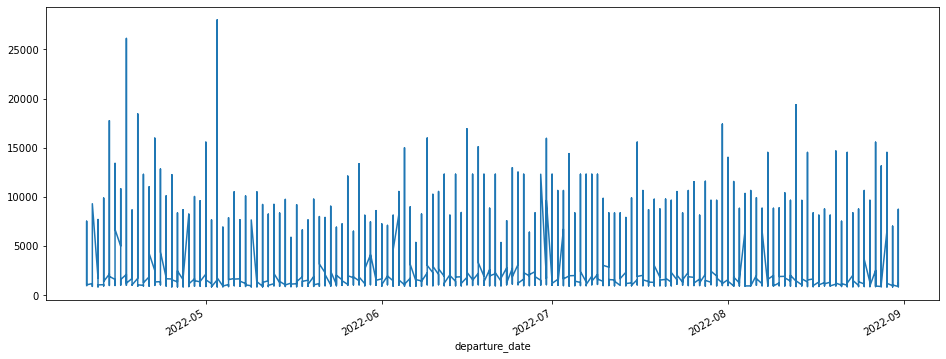

In [42]:
ts.plot(figsize = (16,6));

In [27]:
ts_daily = ts.resample('D').mean()
dicky_fuller(ts_daily)

The data is not stationary with a fuller score of 0.933


Test Statistic                  -0.244237
p-value                          0.933039
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64

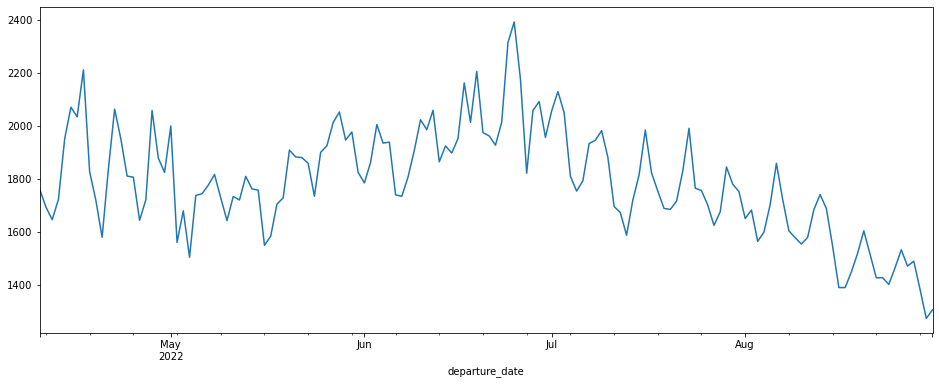

In [41]:
ts_daily.plot(figsize = (16,6));

In [28]:
ts_daily_diff = ts_daily.diff().dropna()
dicky_fuller(ts_daily_diff)

The data is stationary with a fuller score of 0.037


Test Statistic                  -2.975317
p-value                          0.037265
#Lags Used                      13.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64

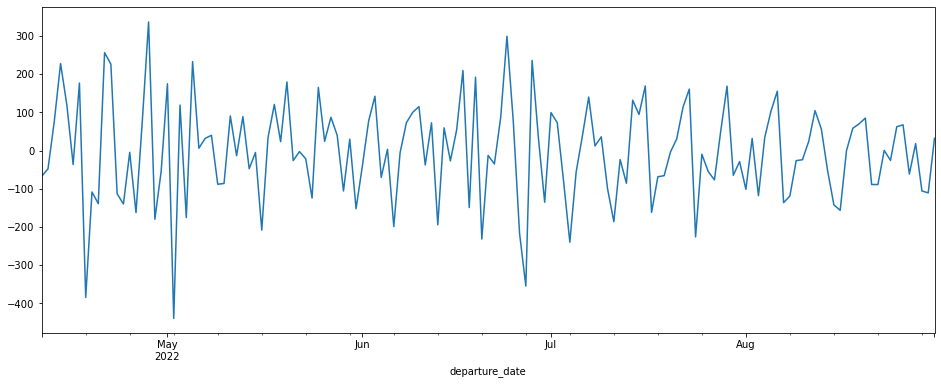

In [43]:
ts_daily_diff.plot(figsize = (16,6));

In [29]:
# Shift data as Naive Bayse for base model
naive = train.shift(1).fillna(value=None, method='backfill', axis=None, limit=None, downcast=None);

In [30]:
from sklearn.metrics import mean_squared_error
mean_squared_error(train, naive, squared=False)

208.59853309722862

In [31]:
naive_test = test.shift(1).fillna(value=None, method='backfill', axis=None, limit=None, downcast=None);

mean_squared_error(test, naive_test, squared=False)

99.9425570860028

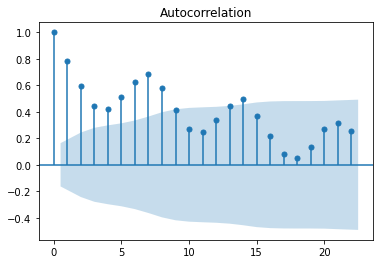

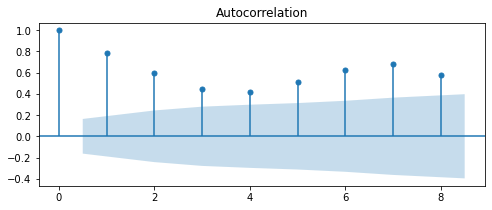

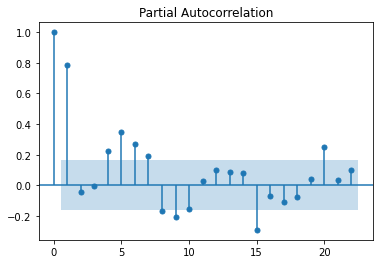

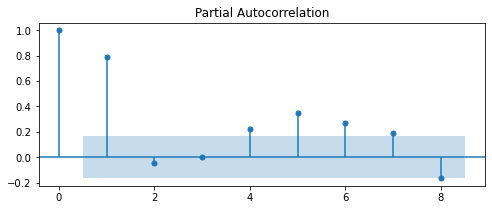

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(ts_daily) #shown below is that an MA term of 3 seems ideal

fig, ax = plt.subplots(figsize=(8,3))
plot_acf(ts_daily, ax=ax, lags=8);

plot_pacf(ts_daily) #shown below is that an AR term of 1 is ideal

fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(ts_daily, ax=ax, lags=8);

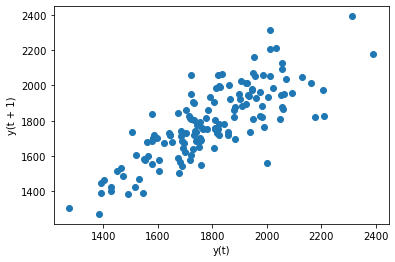

In [33]:
from pandas.plotting import lag_plot
lag_plot(ts_daily)
plt.show()

In [34]:
# from statsmodels.tsa.arima_model import ARIMA
# model = ARIMA(ts_daily, order=(1, 0, 1)) 
# results_ARIMA = model.fit()

import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(ts_daily, order=(5, 1, 1)).fit()
# result = model.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  144
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -869.856
Date:                Sun, 10 Apr 2022   AIC                           1753.712
Time:                        12:57:19   BIC                           1774.452
Sample:                    04-10-2022   HQIC                          1762.140
                         - 08-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1086      0.219     -0.497      0.619      -0.537       0.320
ar.L2         -0.2227      0.076     -2.928      0.003      -0.372      -0.074
ar.L3         -0.3591      0.079     -4.552      0.000      -0.514      -0.204
ar.L4         -0.4049      0.085     -4.758      0.000      -0.572      -0.238
ar.L5         -0.2241      0.137     -1.634      0.102      -0.493       0.045
ma.L1         -0.3109      0.232     -1.343      0.179      -0.765       0.143
sigma2      1.106e+04   1232.454      8.977      0.000    8648.083    1.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 3.51
Prob(Q):                              0.79   Prob(JB):                         0.17
Heteroskedasticity (H):               0.31   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
def dummy_ts():
    """ Create a time series x with price 0. """
    df = pd.DataFrame(columns=['departure_date', 'Price'])
    df['departure_date'] = pd.date_range(start='2022-04-01', end='2022-04-10', freq='D')
    tdf = df.set_index('departure_date')
    
    return tdf

filler_time = dummy_ts()
temporarydf = pd.DataFrame(ts_daily)
combined_tsdf = filler_time.append(temporarydf)
backfilled_tsdf = combined_tsdf.bfill()
backfilled_tsdf

,Price
departure_date,
2022-04-01,1760.088889
2022-04-02,1760.088889
2022-04-03,1760.088889
2022-04-04,1760.088889
2022-04-05,1760.088889
...,...
2022-08-27,1470.635266
2022-08-28,1489.173077
2022-08-29,1383.706731


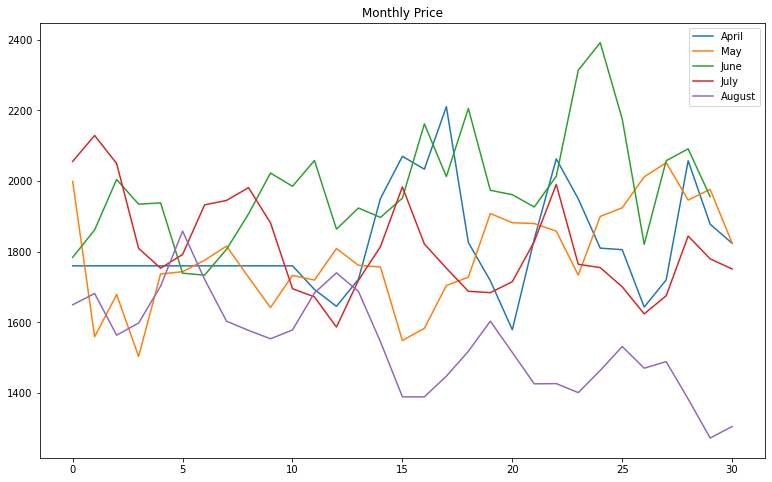

In [84]:
# Use pandas grouper to group values using annual frequency
monthly_groups = backfilled_tsdf.groupby(pd.Grouper(freq ='M'))

month_title_list = ['April', 'May', 'June', 'July', 'August']
# Create a new DataFrame and store yearly values in columns 
apr_monthly = pd.DataFrame()
may_monthly = pd.DataFrame()
jun_monthly = pd.DataFrame()
jul_monthly = pd.DataFrame()
aug_monthly = pd.DataFrame()

n = 0

for mon, group in monthly_groups:
    if n == 0:
        apr_monthly[mon.month] = group.values.ravel()
    if n == 1:
        may_monthly[mon.month] = group.values.ravel()
    if n == 2:
        jun_monthly[mon.month] = group.values.ravel()
    if n == 3:
        jul_monthly[mon.month] = group.values.ravel()
    if n == 4:
        aug_monthly[mon.month] = group.values.ravel()
    n += 1

fig, ax = plt.subplots(figsize=(13,8))
apr_monthly.plot(ax=ax, label = 'April')
may_monthly.plot(ax=ax, label = 'May')
jun_monthly.plot(ax=ax, label = 'June')
jul_monthly.plot(ax=ax, label = 'July')
aug_monthly.plot(ax=ax, label = 'August')
ax.set_title('Monthly Price')
ax.legend([month for month in month_title_list]);

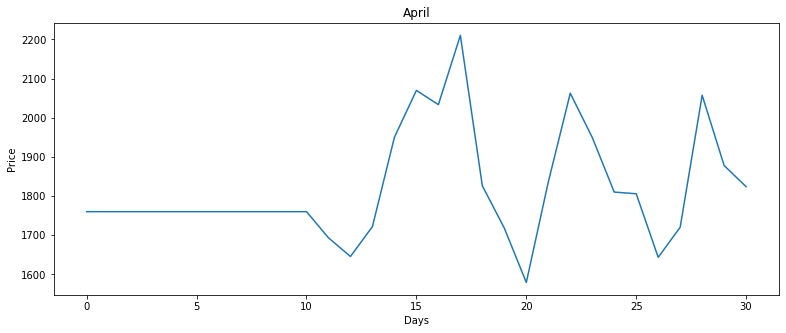

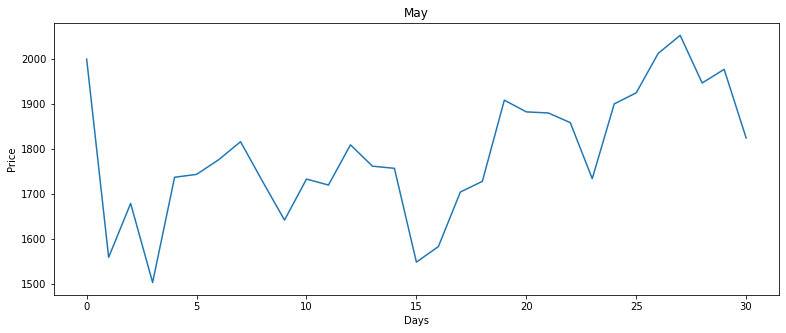

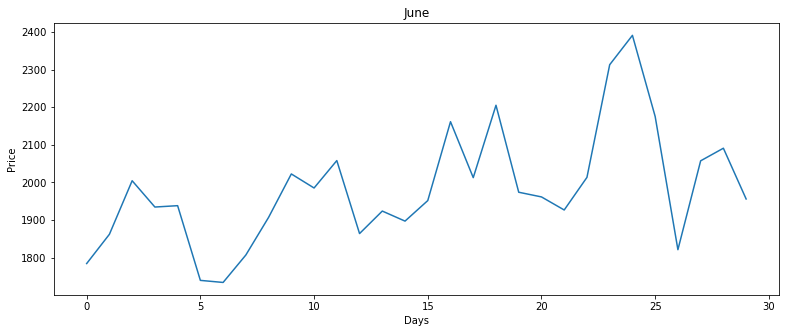

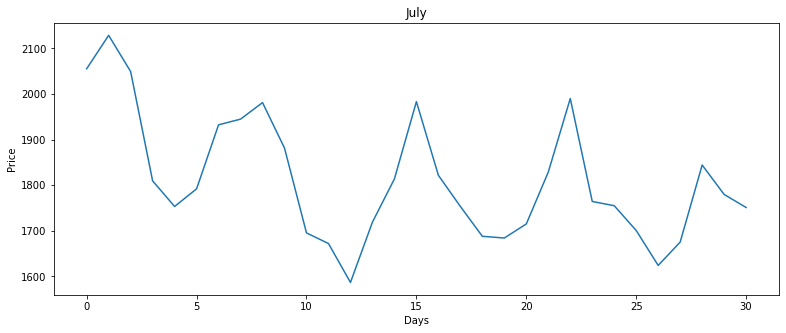

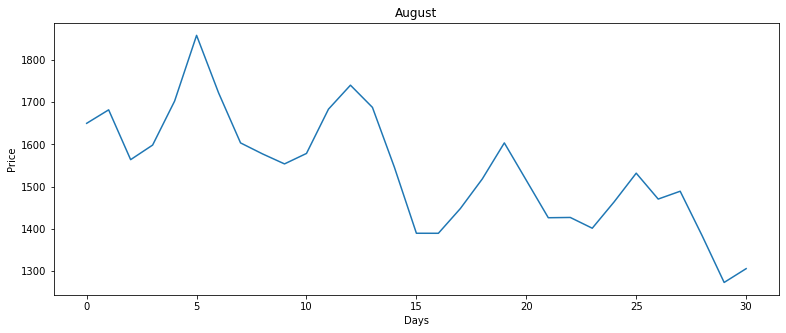

In [38]:
monthly_list = [apr_monthly, may_monthly, jun_monthly,
           jul_monthly, aug_monthly]
i = 0

for month_ts in monthly_list:
    fig, ax = plt.subplots(figsize=(13,5))
    ax.plot(month_ts)
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.set_title(label=month_title_list[i])
    i += 1